In [5]:
import os
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, advanced_activations, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras import regularizers, optimizers
from keras.optimizers import SGD
from keras.models import Model
#import GlobalAvgPool2D
from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
#import cv2
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Input,Concatenate
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
import h5py

In [6]:
def loadData(IMAGE_SIZE):
    images = os.listdir(DATA_DIR)
    d = {} 
    data_all=[]
    train_data = []
    train_pics=[]
    train_labels = []
    test_data=[]
    test_pics=[]
    test_labels=[]
    for idx, dir in enumerate(os.listdir(DATA_DIR)):
            d[idx] = dir
            label = idx
            subdir = os.path.join(DATA_DIR, dir)
            for i, file in enumerate(os.listdir(subdir)):
                #pic = cv2.imread(os.path.join(subdir, file))
                
                pic = misc.imread(os.path.join(subdir, file))
                pic = misc.imresize(pic, (IMAGE_SIZE,IMAGE_SIZE, 3))
                data_all.append((pic, label))
    np.random.shuffle(data_all)
    validation_size = int(len(data_all) * 0.40)
    #validation_data = data_all[:validation_size].copy()
    test_size = int(validation_size * 0.50)
    test_data = data_all[:test_size].copy()
    np.random.shuffle(test_data)
    #np.random.shuffle(validation_data)
    train_data = data_all[test_size:]
    for i in range(len(train_data)):
        train_pics.append(train_data[i][0])
        train_labels.append(train_data[i][1])
    for i in range(len(test_data)):
        test_pics.append(test_data[i][0])
        test_labels.append(test_data[i][1])
    return np.array(train_pics), np.array(train_labels),np.array(test_pics), np.array(test_labels)

In [7]:
def Alexnet(num_classes):
    model = Sequential()
    model.add(Conv2D(filters=96, kernel_size=(11,11),strides=(4,4), padding='valid',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    #model.summary()
    return model

In [ ]:
np.random.seed(3)
#加载数据
IMAGE_SIZE = 227
DATA_DIR = r"E:\分类227\分类"
train_data, train_labels, test_data, test_labels = loadData(IMAGE_SIZE)
#输出训练和测试数据量
# print ("Train data size: ", len(train_data))
# print ("Test data size: ", len(test_data))

train_data=train_data.astype(np.float16)/255
test_data=test_data.astype(np.float16)/255
#将标签量进行转化
train_labels=np_utils.to_categorical(train_labels)
test_labels=np_utils.to_categorical(test_labels)
#设置检查点
# filepath=r"G:\科研\数据集\opendata_VRID\model\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
#设置最佳检查点
filepath=r"E:\分类227\weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
#设置模型
num_classes=4
model=Alexnet(num_classes)
#编译模型
epochs = 5
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum,  decay=decay_rate, nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

#匹配模型
#lrate = LearningRateScheduler(step_decay)
#callbacks_list = [lrate]
history=model.fit(train_data, train_labels,validation_split=0.2, nb_epoch=epochs,batch_size=16,callbacks=callbacks_list)
#测试模型
preds = np.argmax(model.predict(test_data), axis=1)
test_labels = np.argmax(test_labels, axis=1)
print (accuracy_score(test_labels, preds))
#保存模型
#model.save('Alexnet-model(10,64).model')
#记录模型日志
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
#画模型准确率曲线和损失率曲线
plt.plot(epochs, acc, 'ro:', label='Training acc')
plt.plot(epochs, val_acc, 'bo:', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro:', label='Training loss')
plt.plot(epochs, val_loss, 'bo:', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.savefig('graph.png')

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 256 samples, validate on 64 samples
Epoch 1/5


In [5]:
import os
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, advanced_activations, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras import regularizers, optimizers
from keras.optimizers import SGD
from keras.models import Model
#import GlobalAvgPool2D
from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Input,Concatenate
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random

In [ ]:
import matplotlib.pyplot as plt 

import numpy as np 

y = np.arange(1, 3, 0.3) 

plt.plot(y, 'c*--', y+1, 'mo:', y+2, 'kp-.');

plt.show()


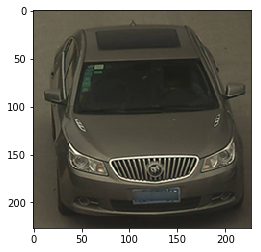

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (227, 227, 3)

In [2]:
import os
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, advanced_activations, Dropout, Flatten, Dense
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import load_model 
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import skimage

def load_image(img_path):
    img = Image.open(img_path)
    return img
def pil_to_nparray(pil_image):
    pil_image.load()
    return np.asarray(pil_image, dtype="float32")
img_path=r'G:\科研\数据集\opendata_VRID\B_4_License_301_2.jpg'
img = load_image(img_path)
img = skimage.io.imread(img_path)
plt.imshow(img)
#img = resize_image(img, 227, 227)
imgs=np.array(img)
model=load_model('Alexnet(5,32).model')
plt.show()
pres=np.argmax(model.predict(imgs), axis=1)
print(pres)

In [ ]:
# Checkpoint the weights for best model on validation accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)

In [ ]:
# Checkpoint the weights when validation accuracy improves
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)

In [ ]:
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# load weights
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# Time Based Learning Rate Decay
from pandas import read_csv
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
dataframe = read_csv("ionosphere.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:34].astype(float)
Y = dataset[:,34]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=epochs, batch_size=28, verbose=2)

In [ ]:
# Drop-Based Learning Rate Decay
import pandas
from pandas import read_csv
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
dataframe = read_csv("ionosphere.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:34].astype(float)
Y = dataset[:,34]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=50, batch_size=28, callbacks=callbacks_list, verbose=2)